<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/jengstrandj_lab4/Lab4/jengstrandj_lab4_ALE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations - ALE**
**Template by Johan Hoffman**

Edited by Josefin Engstrand Jonsson

# **Abstract**

This report show an example on how to use FEniCS to solve the Navier-Stokes equations using an ALE method. We model flow past a cylinder that is deformed over time, and study the time evolution of the drag and lift forces.

# **About the code**

In [ ]:
"""This program is an example file for the course"""

"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2021 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License v2.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

# **Set up environment**

In [21]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time Arbitrary Lagrangian-Eulerian (ALE) finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + ((u-m)\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term. The mesh velocity is denoted by m.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$F(u,p,\phi)= \left<\nu \nabla u\cdot n-pn, \Phi\right>_{\Gamma} = (\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),$

with $\Phi\in V$ a function for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

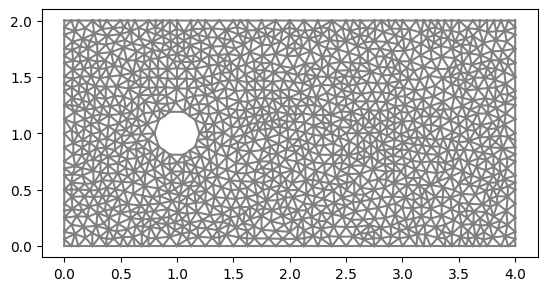

In [22]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5 * H
rc = 0.2


# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)


class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)


class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)


class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)


left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh a mesh with a hole
resolution = 32
mesh = generate_mesh(
    Rectangle(Point(0.0, 0.0), Point(L, H)) - Circle(Point(xc, yc), rc), resolution
)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [23]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [24]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)


class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)


class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)


class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)


class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return (
            on_boundary
            and (not near(x[0], 0.0))
            and (not near(x[0], L))
            and (not near(x[1], 0.0))
            and (not near(x[1], H))
        )


dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression("5.0*fabs(sin(t))", element=Q.ufl_element(), t=0.0)
pout = 0.0
bcp1 = DirichletBC(Q, pout, dbc_right)

# bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

In [25]:
# Set viscosity
nu = 4.0e-3

**Define method parameters**

The mesh will be deformed in two different ways. First, the cylinder will be moved up and down in the vertical direction and simultaneously compressed. Second, the cylinder will be expanded and shrunken repeatedly, but its centerpoint will remain stationary.

In [26]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Mesh deformation in the y-direction only
amp_x = 0.0
amp_y = 1.0e-2

# Define mesh deformation md, mesh velocity w=md/dt
freq = 0.1
t = 0.0

# Deforming and moving the cylinder
md = Expression(
    (
        "amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)",
        "amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*x[1]/H)",
    ),
    L=L,
    H=H,
    t=t,
    amp_x=amp_x,
    amp_y=amp_y,
    freq=freq,
    element=V.ufl_element(),
)

# Deforming, but not moving, the cylinder
# md = Expression(("amp_x*sin(2.0*pi*t*freq)*sin(pi*x[0]/L)","amp_y*sin(2.0*pi*t*freq-0.5*pi)*sin(pi*(x[1]-yc))"), L=L, yc=yc, t=t, amp_x=amp_x, amp_y=amp_y, freq=freq, element = V.ufl_element())

# Set parameters for nonlinear and linear solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5 * mesh.hmin()

**Define variational problem**

In [27]:
# Stabilization parameters
h = CellDiameter(mesh)
u_mag = sqrt(dot(u1, u1))
d1 = 1.0 / sqrt((pow(1.0 / dt, 2.0) + pow(u_mag / h, 2.0)))
d2 = h * u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5 * (u + u0)
um1 = 0.5 * (u1 + u0)

# Momentum variational equation on residual form
Fu = (
    inner((u - u0) / dt + grad(um) * (um1 - md / dt), v) * dx
    - p1 * div(v) * dx
    + nu * inner(grad(um), grad(v)) * dx
    + d1
    * inner(
        (u - u0) / dt + grad(um) * (um1 - md / dt) + grad(p1), grad(v) * (um1 - md / dt)
    )
    * dx
    + d2 * div(um) * div(v) * dx
)
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = (
    d1 * inner((u1 - u0) / dt + grad(um1) * (um1 - md / dt) + grad(p), grad(q)) * dx
    + div(um1) * q * dx
)
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

Drag force:

In [28]:
# Define the direction of the drag force
phi_x_drag = 1.0
phi_y_drag = 0.0

psi_expression_drag = Expression(
    (
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.",
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0.",
    ),
    xc=xc,
    yc=yc,
    rc=rc,
    phi_x=phi_x_drag,
    phi_y=phi_y_drag,
    element=V.ufl_element(),
)
psi_drag = interpolate(psi_expression_drag, V)

drag_force = (
    inner((u1 - u0) / dt + grad(um1) * um1, psi_drag) * dx
    - p1 * div(psi_drag) * dx
    + nu * inner(grad(um1), grad(psi_drag)) * dx
)

# Force normalization
D = 2 * rc
normalization = -2.0 / D

Lift force:

In [29]:
# Define the direction of the lift force
phi_x_lift = 0.0
phi_y_lift = 1.0

psi_expression_lift = Expression(
    (
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.",
        "near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0.",
    ),
    xc=xc,
    yc=yc,
    rc=rc,
    phi_x=phi_x_lift,
    phi_y=phi_y_lift,
    element=V.ufl_element(),
)
psi_lift = interpolate(psi_expression_lift, V)

lift_force = (
    inner((u1 - u0) / dt + grad(um1) * um1, psi_lift) * dx
    - p1 * div(psi_lift) * dx
    + nu * inner(grad(um1), grad(psi_lift)) * dx
)

**Set plotting variables and open export files**

In [30]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 15
plot_freq = 40

# Force computation data
lift_force_array = np.array(0.0)
lift_force_array = np.delete(lift_force_array, 0)
drag_force_array = np.array(0.0)
drag_force_array = np.delete(drag_force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [ ]:
!rm results-NS/*

# Time stepping
T = 30
t = dt

while t < T + DOLFIN_EPS:

    pin.t = t
    #uin.t = t

    md.t = t
    ALE.move(mesh, md)

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute forces
        F_drag = assemble(drag_force)
        F_lift = assemble(lift_force)

        if (t > start_sample_time):
          drag_force_array = np.append(drag_force_array, normalization*F_drag)
          lift_force_array = np.append(lift_force_array, normalization*F_lift)
          time = np.append(time, t)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plot(u1, title=f"Velocity, t={round(t, 2)}")

        plt.figure()
        plot(p1, title=f"Pressure, t={round(t, 2)}")

        plt.figure()
        plot(mesh, title=f"Mesh, t={round(t, 2)}")
        plt.savefig(f"Mesh,t={round(t, 2)}.png")

        plt.figure()
        plt.title(f"Lift force")
        plt.plot(time, lift_force_array)
        plt.savefig(f"Liftforce,t={round(t, 2)}.png")

        plt.figure()
        plt.title(f"Drag force")
        plt.plot(time, drag_force_array)
        plt.savefig(f"Dragforce,t={round(t, 2)}.png")

        plt.show()

        plot_time += T/plot_freq

    # Update time step
    u0.assign(u1)
    t += dt

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

**Deforming and moving the cylinder**

When deforming and moving the cylinder in the vertical direction, the drag and lift forces depend on time as shown in the two plots below.

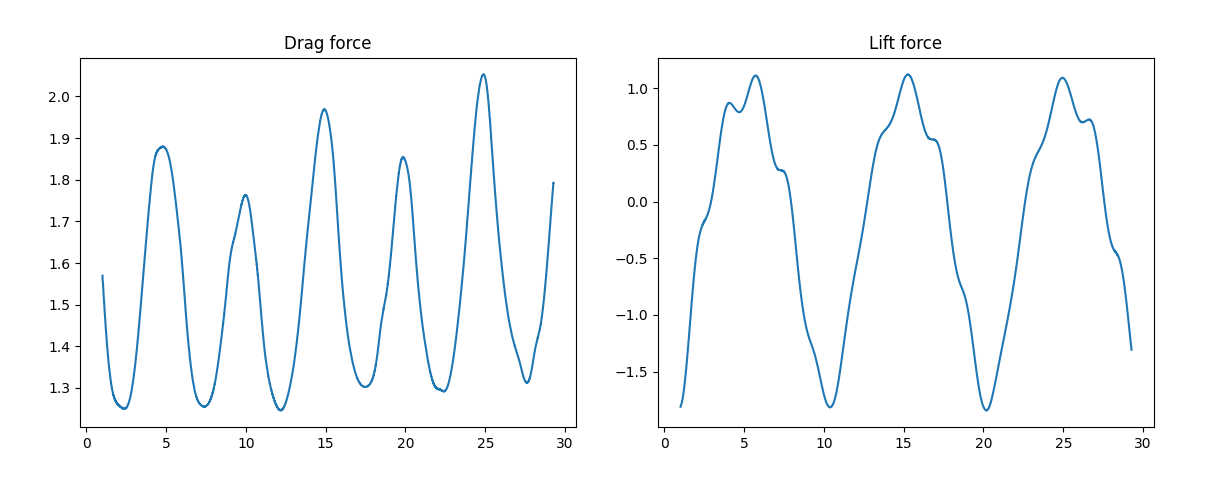

Below is the mesh at four different timepoints. Notice that the drag force is close to a maximum when $t=15.01$ and $t=21.03$, and close to a minimum when $t=18.0$ and $t=22.51$. Hence, local maxima of the drag force occur when the cylinder is undeformed, and local minima when the cylinder is maximally compressed.

Notice, too, that the mesh at timepoints $t=15.01$ and $t=21.03$ approximately correspond to a maximum and a minimum value in the lift force graph, respectively, while those for $t=18.0$ and $t=22.51$ give a nearly zero lift force. Thus, the lift force is largest-in-magnitude when the mesh is undeformed, but close to zero when the cylinder is maximally compressed.

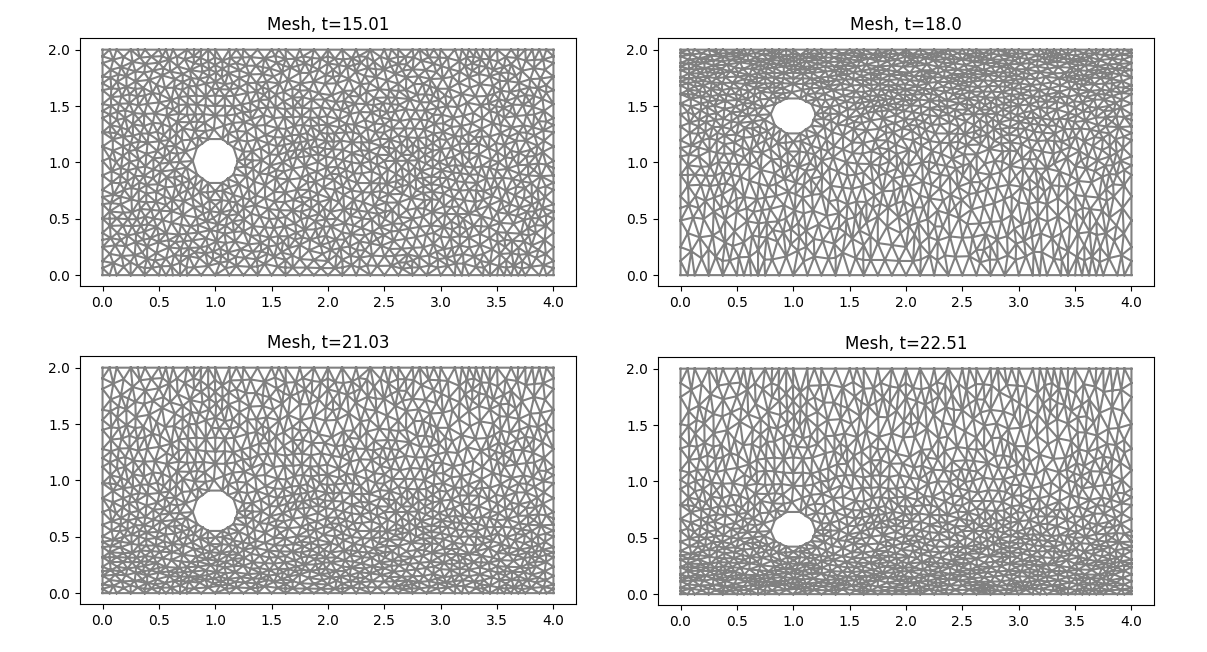

**Deforming, but not moving, the cylinder**

When deforming the cylinder in the vertical direction, without moving its center, we obtain the following plots of the drag and lift forces. The drag force oscillates slower than before, but has a higher amplitude. The lift force has sharper peaks and a slightly smaller amplitude.

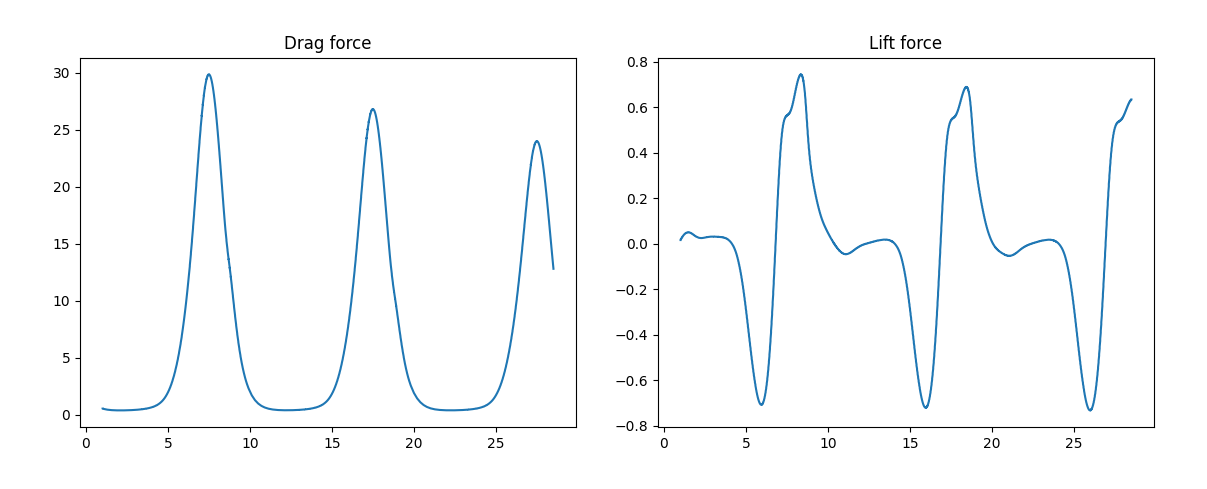

Consider the three mesh plots below. The mesh for $t=18.0$ is associated with a local maximum of the drag force, while that for $t=22.51$ yields a local minimum. This means the drag force peaks when the cylinder is large and wide, and that it is minimal when the cylinder is small and thin.

Moreover, at $t=18.0$, the lift force reaches its maximum, while at $t=22.51$, it approaches zero, and at approximately $t=26.25$, it hits a minimum. This indicates that the lift force is largest-in-magnitude when the hole is large, but near zero when the hole is small.

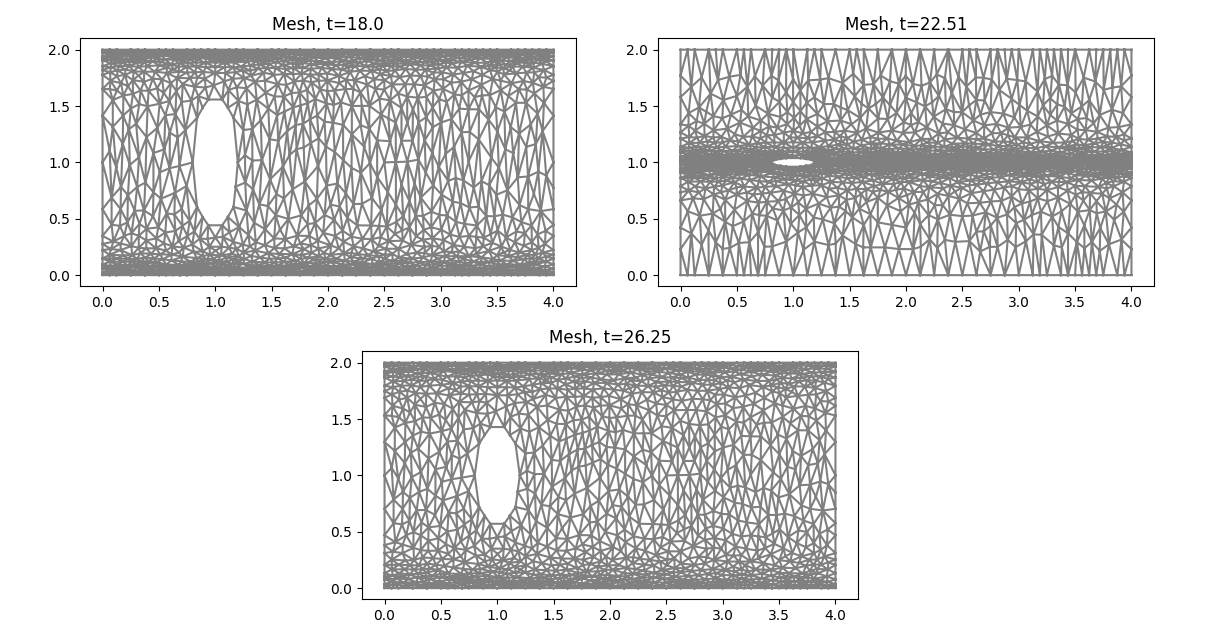

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D using an ALE finite element method. The model problem studied was that of flow past a deforming cylinder. The drag and lift forces were investigated when moving the cylinder in the vertical direction, simultaneously compressing it, as well as when expanding and shrinking the cylinder while keeping the centerpoint stationary. Both the drag force and the lift force were found to decrease in magnitude as the cylinder was compressed.